In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)


print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0",
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import pickle
import shap

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import confusion_matrix, fbeta_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

In [3]:
df = pd.read_csv('../data/CVD_cleaned.csv')
df.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


# Project Phase 1

In [4]:
print('dataset dimension:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print(df.columns)

dataset dimension: (308854, 19)
fraction of missing values in features:
Series([], dtype: float64)
Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')


### EDA

In [5]:
df['Heart_Disease'].value_counts()[1]/len(df)*100

8.085049894124733

<Figure size 500x400 with 0 Axes>

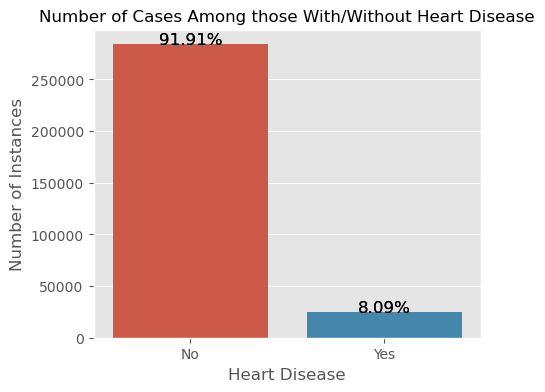

In [6]:
plt.figure(figsize=(5,4))
plt.figure(figsize=(5,4))
g = sns.countplot(data=df, x='Heart_Disease')
sns.countplot(df, x = 'Heart_Disease')
plt.ylabel('Number of Instances')
plt.xlabel('Heart Disease')
plt.title('Number of Cases Among those With/Without Heart Disease', fontsize=12)
total = len(df)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center",
            fontsize = 12);
plt.savefig('../figures/target_variable.png',dpi=300,bbox_inches="tight")

<Axes: xlabel='count', ylabel='Age_Category'>

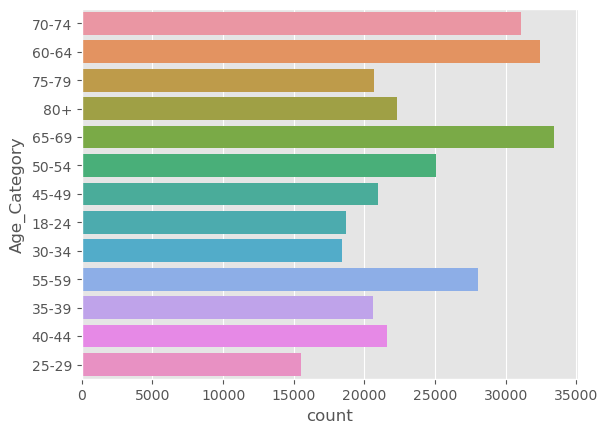

In [7]:
#sns.countplot(df, x = 'General_Health')
sns.countplot(df, y = 'Age_Category')

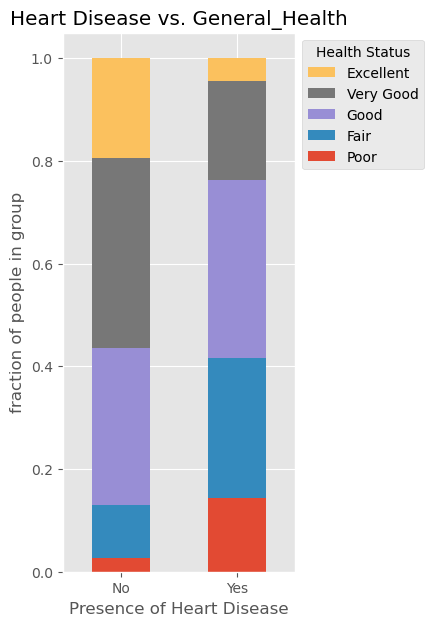

In [8]:
count_matrix = df.groupby(['Heart_Disease','General_Health']).size().unstack()
general_health = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
count_matrix = count_matrix[general_health]
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(3,7))
plt.ylabel('fraction of people in group')
plt.xlabel('Presence of Heart Disease')
plt.xticks(rotation = 0)
plt.title('Heart Disease vs. General_Health')
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()

plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1,1), title='Health Status')

plt.savefig('../figures/general_health.png',dpi=300,bbox_inches="tight")


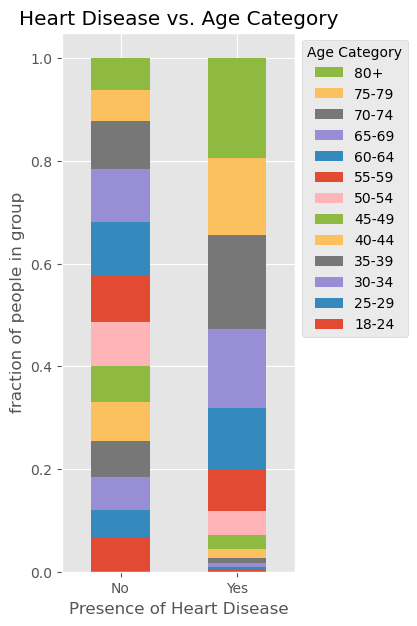

In [9]:
count_matrix = df.groupby(['Heart_Disease','Age_Category']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(3,7))
plt.ylabel('fraction of people in group')
plt.xlabel('Presence of Heart Disease')
plt.xticks(rotation = 0)
plt.title('Heart Disease vs. Age Category')
handles, labels = plt.gca().get_legend_handles_labels()
handles.reverse()
labels.reverse()

plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1,1), title='Age Category')
plt.savefig('../figures/age_category.png',dpi=300,bbox_inches="tight")

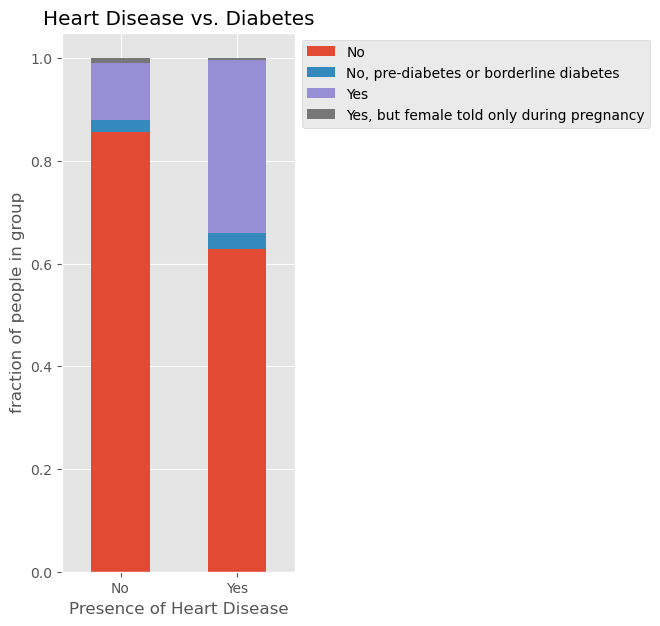

In [10]:
count_matrix = df.groupby(['Heart_Disease','Diabetes']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(3,7))
plt.ylabel('fraction of people in group')
plt.xlabel('Presence of Heart Disease')
plt.xticks(rotation = 0)
plt.title('Heart Disease vs. Diabetes')
plt.legend(loc='upper left', bbox_to_anchor=(1,1)) 
plt.savefig('../figures/diabetes.png',dpi=300,bbox_inches="tight")

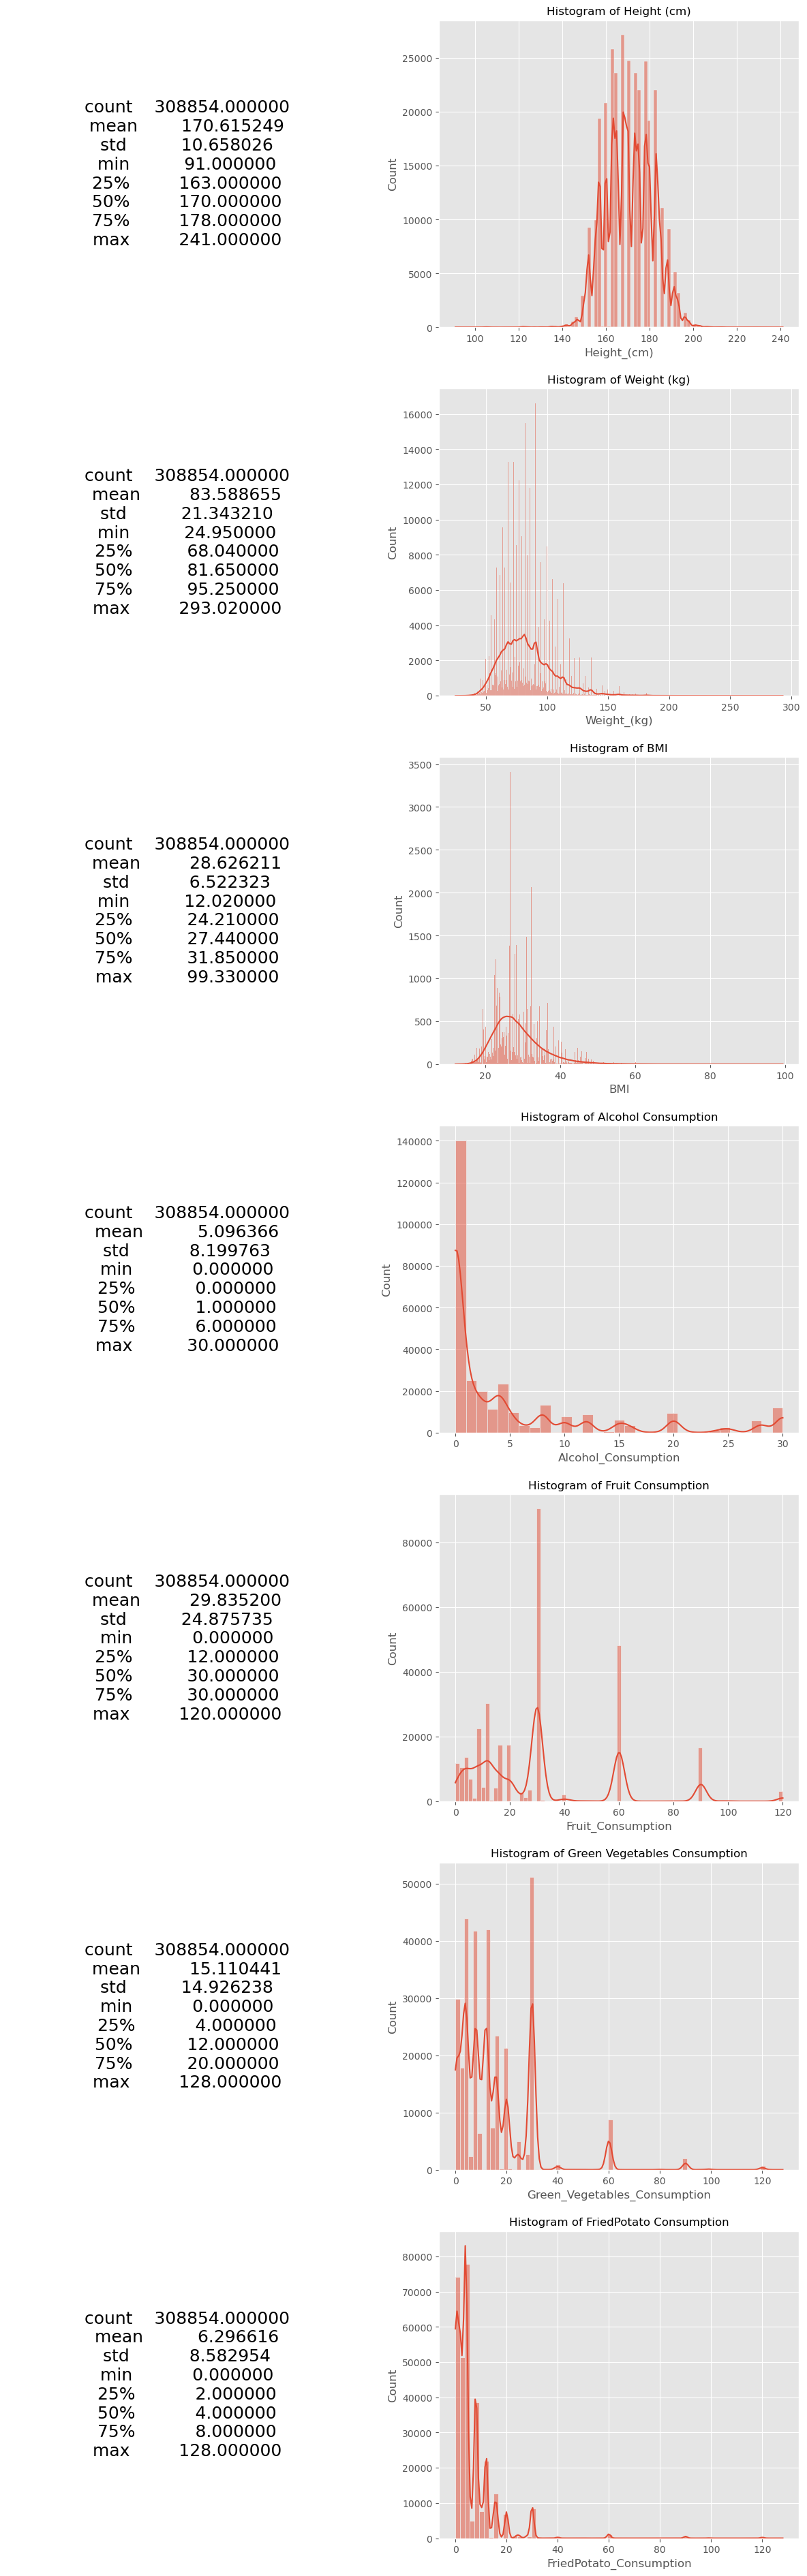

In [11]:
continuous_features = ['Height_(cm)', 'Weight_(kg)', 'BMI','Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
fig, axes = plt.subplots(nrows=len(continuous_features), ncols=2, figsize=(15, 48))

for i, col in enumerate(continuous_features):
    axes[i, 0].axis('off')
    stats = df[col].describe().to_string()
    axes[i, 0].text(0.5, 0.5, stats, fontsize=18, ha='center', va='center')
    

    sns.histplot(df[col], bins=df[col].nunique(), kde=True, ax=axes[i, 1])

    title = f'Histogram of {col.replace("_", " ")}'
    axes[i, 1].set_title(title).set_size(12)

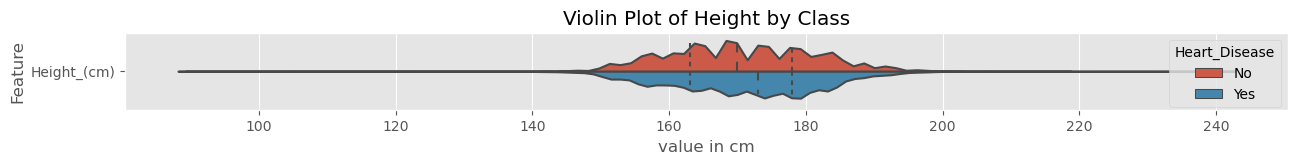

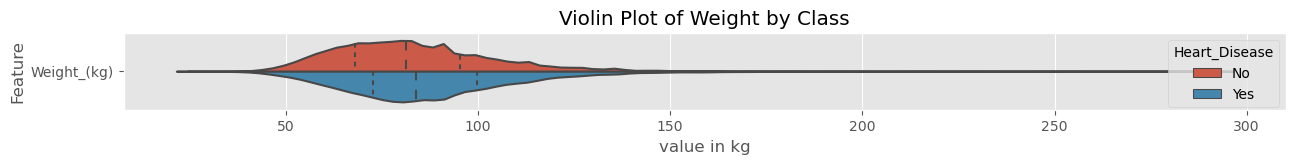

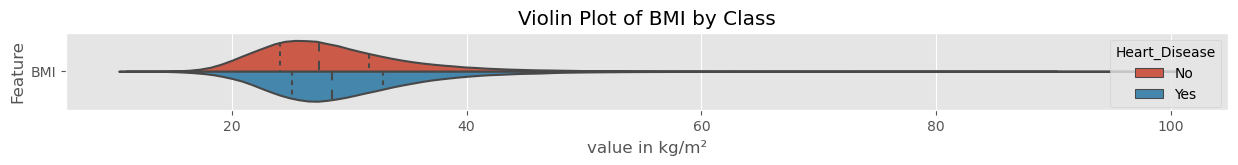

In [12]:
continuous1_features = ['Height_(cm)', 'Weight_(kg)', 'BMI']
xlabel = ['cm', 'kg', 'kg/m²']
df_melted = df.melt(id_vars='Heart_Disease', value_vars=continuous1_features, var_name='Feature', value_name='Value')
plt.figure(figsize=(15,1))
sns.violinplot(y='Feature', x='Value', hue='Heart_Disease', data=df_melted[df_melted['Feature'] == 'Height_(cm)'], split=True, inner='quart', orient='hue_order=')
plt.title('Violin Plot of Height by Class')
plt.xlabel('value in cm')
plt.savefig('../figures/continuousheight.png',dpi=300,bbox_inches="tight")
plt.figure(figsize=(15,1))
sns.violinplot(y='Feature', x='Value', hue='Heart_Disease', data=df_melted[df_melted['Feature'] == 'Weight_(kg)'], split=True, inner='quart', orient='hue_order=')
plt.title('Violin Plot of Weight by Class')
plt.xlabel('value in kg')
plt.savefig('../figures/continuousweight.png',dpi=300,bbox_inches="tight")
plt.figure(figsize=(15,1))
sns.violinplot(y='Feature', x='Value', hue='Heart_Disease', data=df_melted[df_melted['Feature'] == 'BMI'], split=True, inner='quart', orient='hue_order=')
plt.title('Violin Plot of BMI by Class')
plt.xlabel('value in kg/m²')
plt.savefig('../figures/continuousbmi.png',dpi=300,bbox_inches="tight")

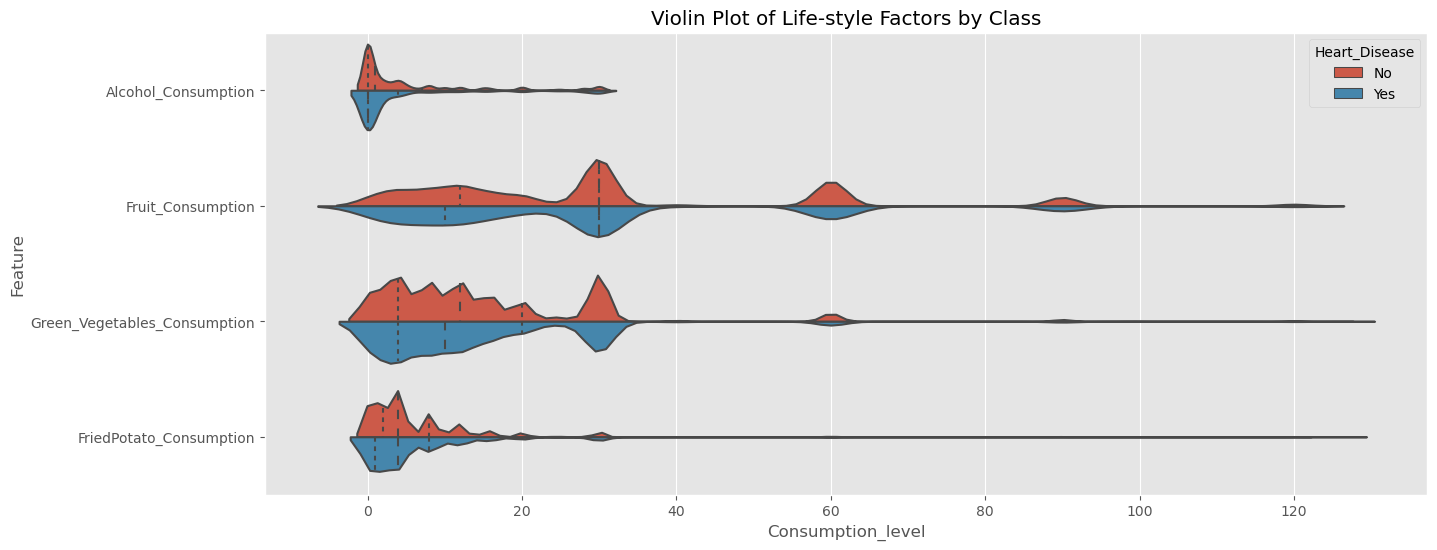

In [13]:
continuous2_features = ['Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']
df_melted = df.melt(id_vars='Heart_Disease', value_vars=continuous2_features, var_name='Feature', value_name='Value')
plt.figure(figsize=(15,6))
sns.violinplot(y='Feature', x='Value', hue='Heart_Disease', data=df_melted, split=True, inner='quart', orient='h')
plt.xlabel('Consumption_level')
plt.ylabel('Feature')
plt.title('Violin Plot of Life-style Factors by Class')
plt.savefig('../figures/continuous2.png',dpi=300,bbox_inches="tight")

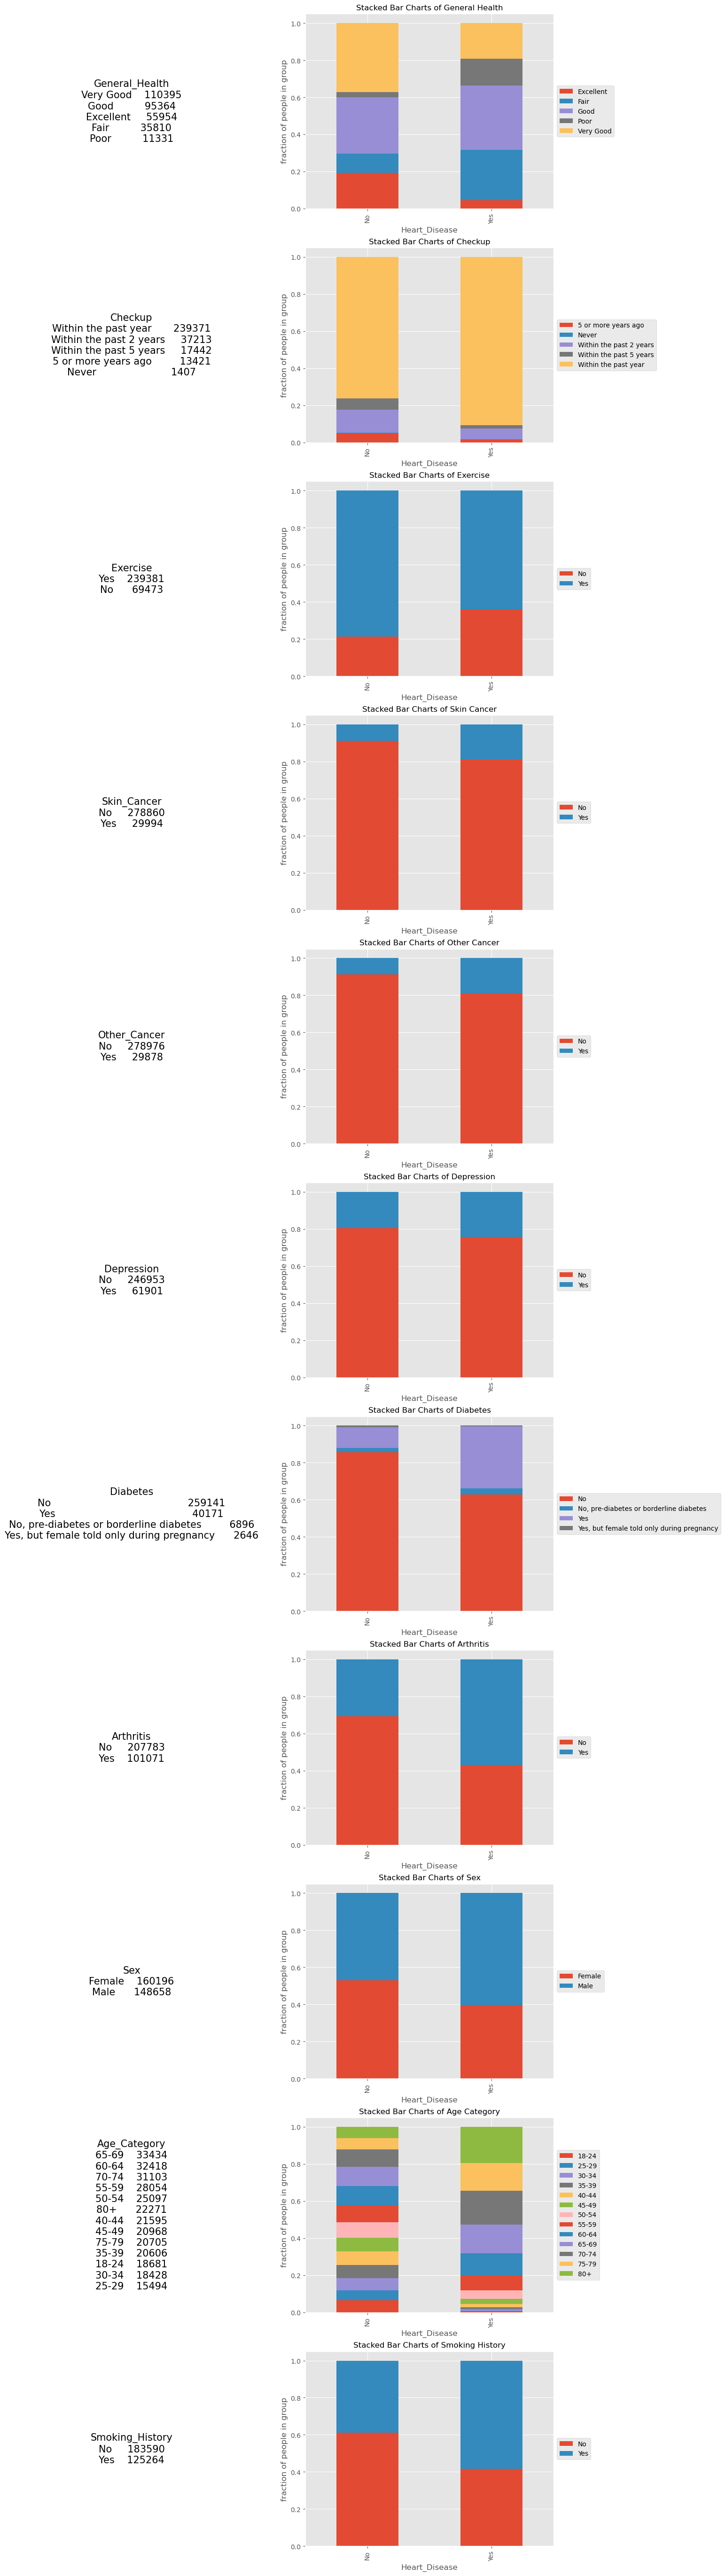

In [14]:
categorical_features = ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer',
                        'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
                        'Age_Category','Smoking_History']

fig, axes = plt.subplots(nrows=len(categorical_features), ncols=2, figsize=(15, 70))

for i, col in enumerate(categorical_features):
    # Descriptive statistics
    axes[i, 0].axis('off')
    stats = df[col].value_counts().to_string()
    axes[i, 0].text(0.5, 0.5, stats, fontsize=15, ha='center', va='center')


    count_matrix = df.groupby(['Heart_Disease',col]).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
    count_matrix_norm.plot(kind='bar', stacked=True, ax=axes[i, 1])
    
    axes[i, 1].set_ylabel('fraction of people in group')
    axes[i, 1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    title = f'Stacked Bar Charts of {col.replace("_", " ")}'
    axes[i, 1].set_title(title, fontsize=12)

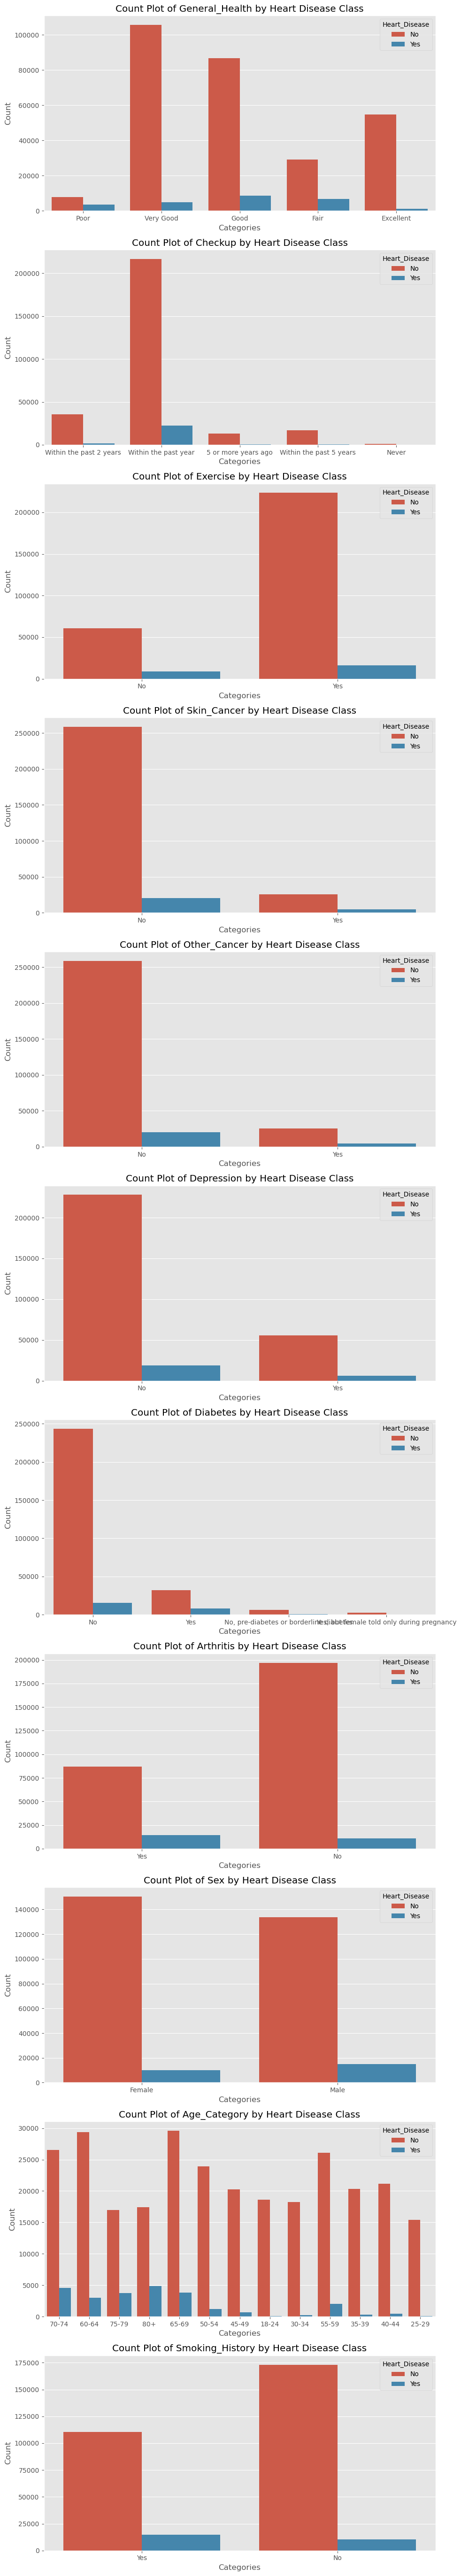

In [15]:
categorical_features = ['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer',
                        'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
                        'Age_Category','Smoking_History']
                        
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(10, len(categorical_features) * 5))

for i, feature in enumerate(categorical_features):
    sns.countplot(ax=axes[i], x=feature, hue='Heart_Disease', data=df)
    axes[i].set_title(f'Count Plot of {feature} by Heart Disease Class')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Count')

plt.tight_layout()
#plt.savefig('../figures/categorical.png', dpi=300, bbox_inches="tight")
plt.show()

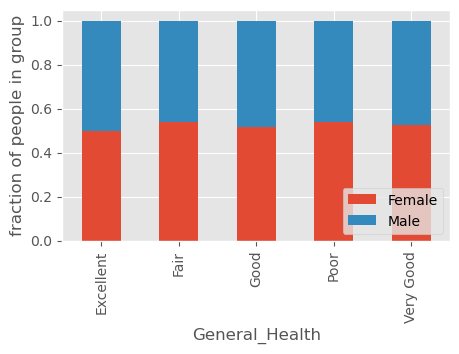

In [16]:
count_matrix = df.groupby(['General_Health','Sex']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(5,3))
plt.ylabel('fraction of people in group')
plt.legend(loc=4)

In [17]:
continuous_features = ['Height_(cm)', 'Weight_(kg)', 'BMI','Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

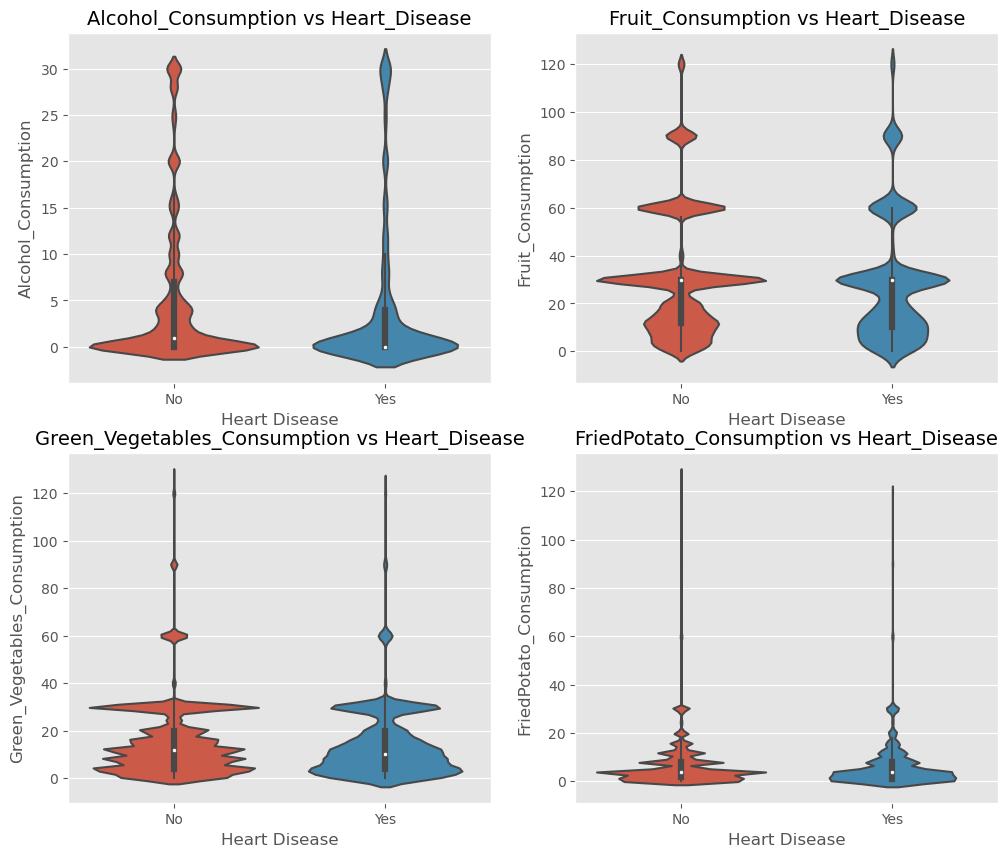

In [18]:
col_names = df.columns[-4:]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 10))
ax = ax.flatten()
for i, col in enumerate(col_names):
    sns.violinplot(data=df, x='Heart_Disease', y=col, ax=ax[i])
    ax[i].set_title(f'{col} vs Heart_Disease', fontsize = '14')
    ax[i].set_ylabel(f'{col}',fontsize = '12')
    ax[i].set_xlabel('Heart Disease',fontsize = '12');

#plt.savefig('../figures/lifestyle_factors.png',dpi=300,bbox_inches="tight")

<Axes: xlabel='Heart_Disease', ylabel='BMI'>

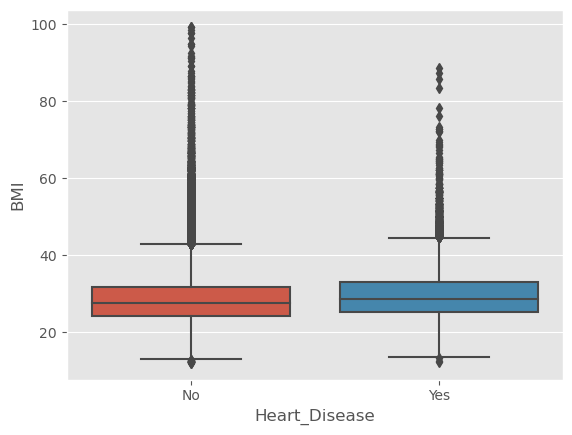

In [19]:
sns.boxplot(df,  x='Heart_Disease', y='BMI')
#df[['Age_Category','BMI','Height_(cm)','Weight_(kg)']].sort_values('BMI',ascending=False)

The figure layout has changed to tight


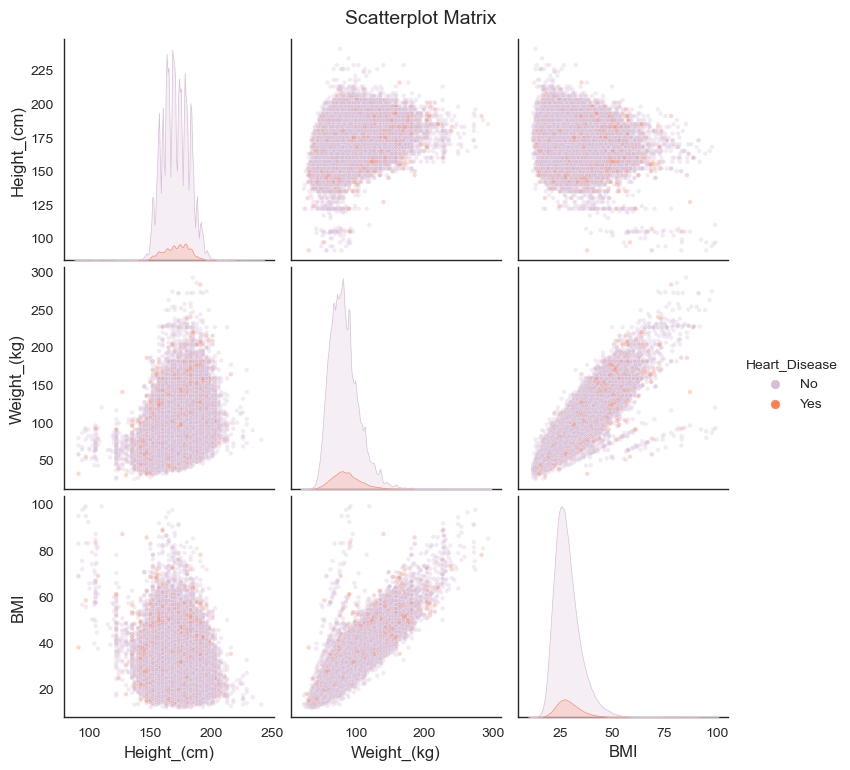

In [20]:
sns.set_style("white")
#continuous_features
g=sns.pairplot(df, vars=df.columns[11:14], hue='Heart_Disease', diag_kind='kde',
             palette={"Yes": "coral", "No": "thistle"}, plot_kws={'alpha': 0.3, 's': 10})
#g=sns.pairplot(df, vars=continuous_features, hue='Heart_Disease', diag_kind='kde',
#             palette={"Yes": "coral", "No": "thistle"}, plot_kws={'alpha': 0.3, 's': 10})

g.fig.suptitle('Scatterplot Matrix', y=1.02,fontsize = 14)

plt.gca().spines["left"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False);
plt.savefig('../figures/scatterplotmatrix.png',dpi=300,bbox_inches="tight")

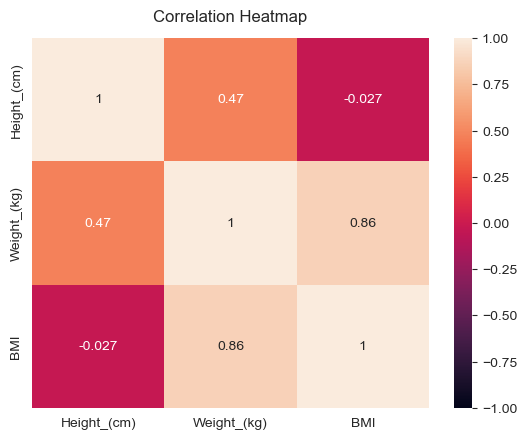

In [21]:
corr = df[df.columns[11:14]].corr()
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig('../figures/correlationheatmap.png',dpi=300,bbox_inches="tight");

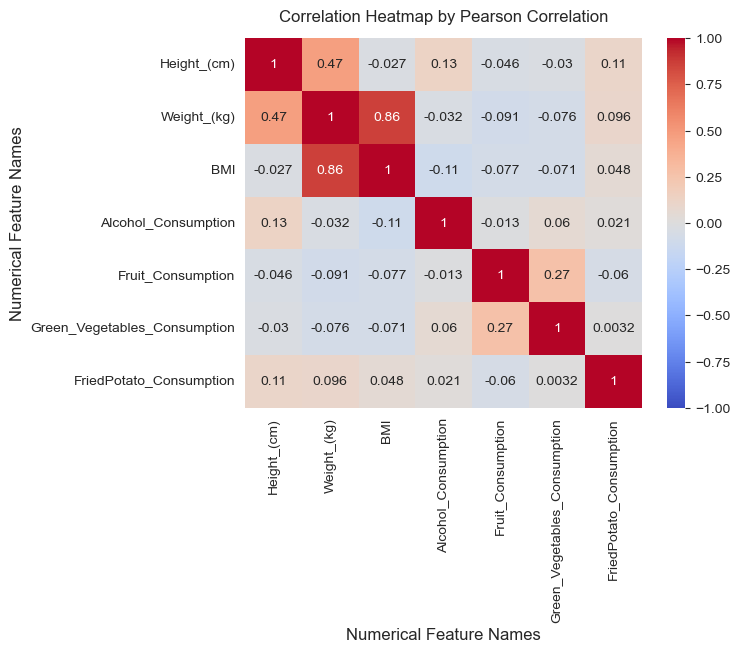

In [22]:
corr = df[continuous_features].corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True)
plt.xlabel("Numerical Feature Names")
plt.ylabel("Numerical Feature Names")
plt.title('Correlation Heatmap by Pearson Correlation', fontdict={'fontsize':12}, pad=12)
plt.savefig('../figures/correlationheatmap.png',dpi=300,bbox_inches="tight");

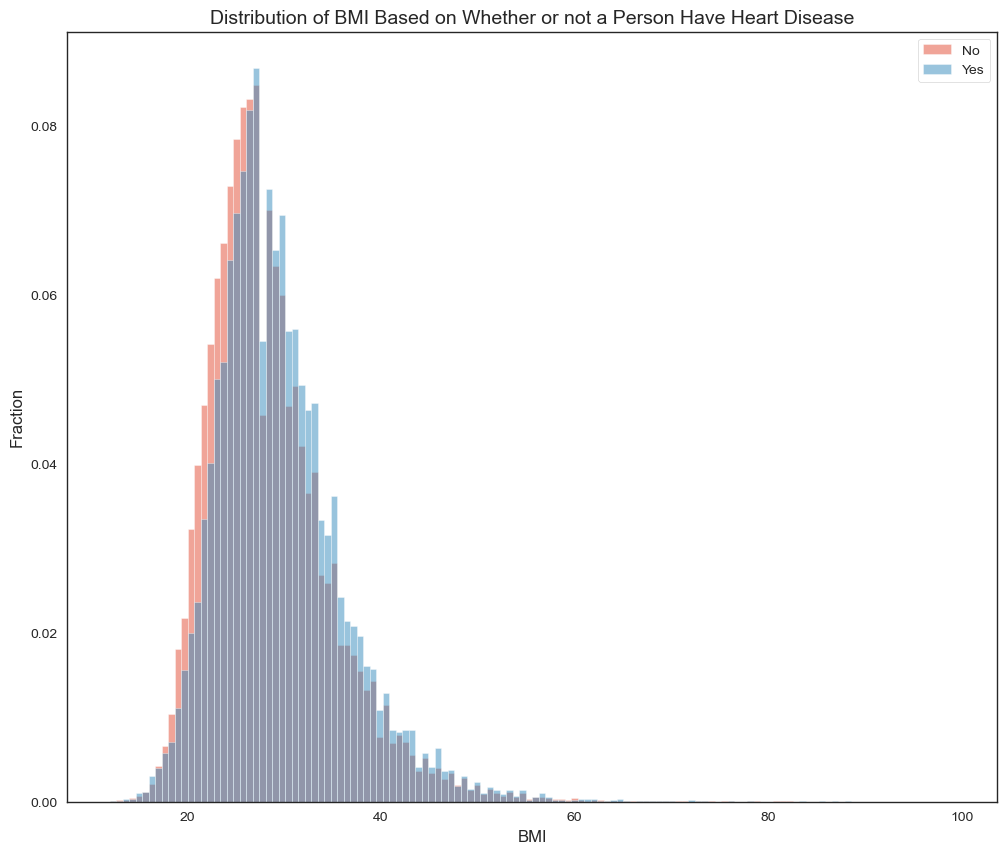

In [23]:
categories = df['Heart_Disease'].unique()
bin_range = (df['BMI'].min(),df['BMI'].max())

plt.figure(figsize=(12,10))

for c in categories:
    plt.hist(df[df['Heart_Disease']==c]['BMI'],alpha=0.5,label=c,range=bin_range,bins=130,density=True)
plt.legend()
plt.ylabel('Fraction', fontsize = 12)
plt.xlabel('BMI', fontsize = 12)
plt.title('Distribution of BMI Based on Whether or not a Person Have Heart Disease', fontsize=14)
plt.show()

### Splitting

In [24]:
random_state = 56

X = df.drop(labels=['Heart_Disease'], axis=1)
y = df['Heart_Disease']

X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,stratify=y,random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,stratify=y_other,random_state=random_state)

print('**balance with stratification:**')
print('y_train\n:',np.unique(y_train,return_counts=True))
print('y_val\n:',np.unique(y_val,return_counts=True))
print('y_test\n:',np.unique(y_test,return_counts=True))

**balance with stratification:**
y_train
: (array(['No', 'Yes'], dtype=object), array([170329,  14983]))
y_val
: (array(['No', 'Yes'], dtype=object), array([56777,  4994]))
y_test
: (array(['No', 'Yes'], dtype=object), array([56777,  4994]))


### Preprocessing

In [25]:
print('data dimensions:',df.shape)
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:\n',perc_missing_per_ftr[perc_missing_per_ftr > 0])

data dimensions: (308854, 19)
fraction of missing values in features:
 Series([], dtype: float64)


In [26]:
cat_ftrs = ['Checkup','Exercise','Skin_Cancer','Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex','Smoking_History']
ordinal_ftrs = ['General_Health','Age_Category',]
ordinal_cats = [['Poor','Fair','Good','Very Good','Excellent'],\
               ['18-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79','80+']]
num_ftrs = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

In [27]:
# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [28]:
X_prep = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep, columns=feature_names, index=X_train.index)
print('X_train before preprocessing:', X_train.shape)
print('X_train after preprocessing:', df_train.shape)

df_val = preprocessor.transform(X_val)
df_CV = pd.DataFrame(data=df_val, columns=feature_names, index=X_val.index)
print('X_val before preprocessing:', X_val.shape)
print('X_val after preprocessing:', df_CV.shape)

df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test, columns=feature_names, index=X_test.index)
print('X_test before preprocessing:', X_test.shape)
print('X_test after preprocessing:', df_test.shape)

print('preprocessed features:', feature_names)

X_train before preprocessing: (185312, 18)
X_train after preprocessing: (185312, 32)
X_val before preprocessing: (61771, 18)
X_val after preprocessing: (61771, 32)
X_test before preprocessing: (61771, 18)
X_test after preprocessing: (61771, 32)
preprocessed features: ['num__Height_(cm)' 'num__Weight_(kg)' 'num__BMI'
 'num__Alcohol_Consumption' 'num__Fruit_Consumption'
 'num__Green_Vegetables_Consumption' 'num__FriedPotato_Consumption'
 'cat__Checkup_5 or more years ago' 'cat__Checkup_Never'
 'cat__Checkup_Within the past 2 years'
 'cat__Checkup_Within the past 5 years'
 'cat__Checkup_Within the past year' 'cat__Exercise_No'
 'cat__Exercise_Yes' 'cat__Skin_Cancer_No' 'cat__Skin_Cancer_Yes'
 'cat__Other_Cancer_No' 'cat__Other_Cancer_Yes' 'cat__Depression_No'
 'cat__Depression_Yes' 'cat__Diabetes_No'
 'cat__Diabetes_No, pre-diabetes or borderline diabetes'
 'cat__Diabetes_Yes'
 'cat__Diabetes_Yes, but female told only during pregnancy'
 'cat__Arthritis_No' 'cat__Arthritis_Yes' 'cat__Sex_F

In [29]:
full_prep_train = pd.concat([df_train,y_train], axis = 1)
print(full_prep_train.shape)
full_prep_val = pd.concat([df_CV,y_val], axis = 1)
print(full_prep_val.shape)
full_prep_test = pd.concat([df_test,y_test], axis = 1)
print(full_prep_test.shape)

full_prep = pd.concat([full_prep_train,full_prep_val], ignore_index = True)
full_prep = pd.concat([full_prep,full_prep_test], ignore_index = True)
print(full_prep.shape)
full_prep.to_csv('../data/CVD_preprocessed.csv')

(185312, 33)
(61771, 33)
(61771, 33)
(308854, 33)


# Project Phase 2

In [30]:
df = pd.read_csv('../data/CVD_cleaned.csv')
df.head()

random_state = 56

X = df.drop(labels=['Heart_Disease'], axis=1)
y = df['Heart_Disease']

label_mapping = {'No': 0, 'Yes': 1}
y = y.map(label_mapping)

N, Y = df['Heart_Disease'].value_counts()
baseline_recall = Y/(N+Y)
print('baseline recall for the entire dataset is', baseline_recall)

baseline recall for the entire dataset is 0.08085049894124732


### Load training results

In [31]:
with open('../results/rf_results_final.pkl', 'rb') as file:
    data = pickle.load(file)
    rf_scores = data['scores']
    rf_models = data['models']
    rf_test_sets = data['test_sets']

In [32]:
with open('../results/xgb_results_1204.pkl', 'rb') as file:
    data = pickle.load(file)
    xgb_scores = data['scores']
    xgb_models = data['models']
    xgb_test_sets = data['test_sets']

In [33]:
with open('../results/lg_results_final.pkl', 'rb') as file:
    data = pickle.load(file)
    lg_scores = data['scores']
    lg_models = data['models']
    lg_test_sets = data['test_sets']

In [34]:
with open('../results/svc_results_24709.pkl', 'rb') as file:
    data = pickle.load(file)
    svc_scores = data['scores']
    svc_models = data['models']
    svc_test_sets = data['test_sets']

## Model test score differences

In [35]:
rf_score = pd.DataFrame(rf_scores)
rf_score
rf_train_recall = rf_score[rf_score['dataset'] == 'train']['recall']
rf_val_recall = rf_score[rf_score['dataset'] == 'validation']['recall']
rf_test_recall = rf_score[rf_score['dataset'] == 'test']['recall']

print('train recall mean:',np.mean(rf_train_recall))
print('validation recall mean:',np.mean(rf_val_recall))
print('test recall mean:',np.mean(rf_test_recall))
print('test recall standard deviation:',np.std(rf_test_recall))
print(round((np.mean(rf_test_recall)-baseline_recall)/np.std(rf_test_recall),4),'standard deviations above the baseline')

train recall mean: 0.9244210104785424
validation recall mean: 0.9234281137364839
test recall mean: 0.9242290748898678
test recall standard deviation: 0.01990295797470321
42.3745 standard deviations above the baseline


In [36]:
lg_score = pd.DataFrame(lg_scores)
lg_score
lg_train_recall = lg_score[lg_score['dataset'] == 'train']['recall']
lg_val_recall = lg_score[lg_score['dataset'] == 'validation']['recall']
lg_test_recall = lg_score[lg_score['dataset'] == 'test']['recall']

print('train recall mean:',np.mean(lg_train_recall))
print('validation recall mean:',np.mean(lg_val_recall))
print('test recall mean:',np.mean(lg_test_recall))
print('test recall standard deviation:',np.std(lg_test_recall))
print(round((np.mean(lg_test_recall)-baseline_recall)/np.std(lg_test_recall),4),'standard deviations above the baseline')

train recall mean: 0.7906026830407795
validation recall mean: 0.7902282739287144
test recall mean: 0.7912294753704445
test recall standard deviation: 0.008056132421279184
88.1787 standard deviations above the baseline


In [37]:
xgb_score = pd.DataFrame(xgb_scores)
xgb_score
xgb_train_recall = xgb_score[xgb_score['dataset'] == 'train']['recall']
xgb_val_recall = xgb_score[xgb_score['dataset'] == 'validation']['recall']
xgb_test_recall = xgb_score[xgb_score['dataset'] == 'test']['recall']

print('train recall mean:',np.mean(xgb_train_recall))
print('validation recall mean:',np.mean(xgb_val_recall))
print('test recall mean:',np.mean(xgb_test_recall))
print('test recall standard deviation:',np.std(xgb_test_recall))
print(round((np.mean(xgb_test_recall)-baseline_recall)/np.std(xgb_test_recall),4),'standard deviations above the baseline')

train recall mean: 0.8651271440966429
validation recall mean: 0.8626351621946335
test recall mean: 0.8657989587505007
test recall standard deviation: 0.004295422563970166
182.7407 standard deviations above the baseline


In [38]:
svc_score = pd.DataFrame(svc_scores)
svc_score
svc_train_recall = svc_score[svc_score['dataset'] == 'train']['recall']
svc_val_recall = svc_score[svc_score['dataset'] == 'validation']['recall']
svc_test_recall = svc_score[svc_score['dataset'] == 'test']['recall']

print('train recall mean:',np.mean(svc_train_recall))
print('validation recall mean:',np.mean(svc_train_recall))
print('test recall mean:',np.mean(svc_test_recall))
print('test recall standard deviation:',np.std(svc_test_recall))
print(round((np.mean(svc_test_recall)-baseline_recall)/np.std(svc_test_recall),4),'standard deviations above the baseline')

train recall mean: 0.8589687969297515
validation recall mean: 0.8589687969297515
test recall mean: 0.8576576576576576
test recall standard deviation: 0.005358862388117758
144.9575 standard deviations above the baseline


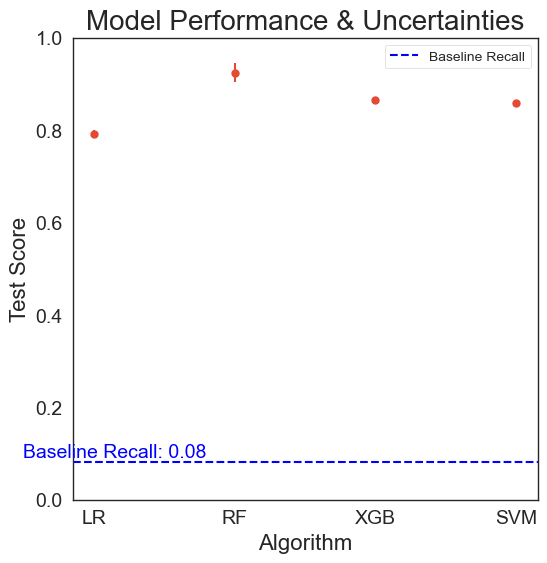

In [39]:
model_means = [np.mean(lg_test_recall),np.mean(rf_test_recall),np.mean(xgb_test_recall), \
               np.mean(svc_test_recall)
               ]
model_stds = [np.std(lg_test_recall),np.std(rf_test_recall),np.std(xgb_test_recall), \
               np.std(svc_test_recall)
               ]
plt.figure(figsize=(6,6))
plt.errorbar(['LR','RF','XGB','SVM'], model_means, yerr=model_stds, fmt='o', markersize = 5)
plt.axhline(y= baseline_recall , color='b', linestyle='--', label='Baseline Recall')
plt.text(x=-0.5, y=baseline_recall+0.01, s=f'Baseline Recall: {baseline_recall:.2f}', color='b', fontsize = 14)
plt.legend()
plt.title('Model Performance & Uncertainties', fontsize = 20)
plt.ylim(0,1)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14) 
plt.xlabel('Algorithm', fontsize = 16)
plt.ylabel('Test Score',fontsize = 16);
plt.savefig('../figures/model_performance.png',dpi=300,bbox_inches="tight")

In [40]:
best_model_test = pd.DataFrame(rf_scores) 

best_model_test_scores = best_model_test[best_model_test['dataset'] == 'test']['recall']
best_model_test_scores.reset_index(drop=True, inplace=True)

best_index = best_model_test_scores.idxmax() 

final_best_model = rf_models[best_index] 
y_pred = final_best_model.predict(rf_test_sets[best_index]['X_test']) 

In [41]:
with open('../results/final_model_results.pkl', 'wb') as file:
    pickle.dump({'final_best_model': final_best_model, 
                 'X_test': rf_test_sets[best_index]['X_test'], 
                 'y_test': rf_test_sets[best_index]['y_test']}, file)
file.close()

## Model Evaluation

In [42]:
with open('../results/final_model_results.pkl', 'rb') as file:
    data = pickle.load(file)
    model = data['final_best_model']
    X_test = data['X_test']
    y_test = data['y_test']

In [43]:
y_pred = model[1].predict(model[0].transform(X))
prediction = pd.DataFrame(y_pred, columns=['predictions']).to_csv('../results/prediction.csv')

Recall: 0.94
Precision: 0.13
F2 Score: 0.41


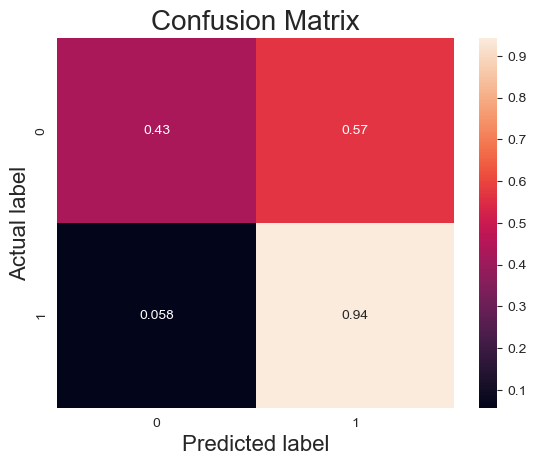

In [44]:



y_true = np.array(y_test)
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_true, y_pred, normalize = 'true')
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f2_score = fbeta_score(y_true, y_pred, beta=2)

sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix', fontsize = 20)
plt.ylabel('Actual label', fontsize = 16)
plt.xlabel('Predicted label', fontsize =16)
plt.savefig('../figures/confusion_matrix.png',dpi=300,bbox_inches="tight")

print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F2 Score: {f2_score:.2f}')

## Model Interpretation

### Global

#### Global Feature Importance - general

In [45]:
model_extract = model.get_params()['randomforestclassifier']
model_extract

RandomForestClassifier(class_weight={0: 1, 1: 15}, max_depth=1,
                       max_features=0.25, n_jobs=-1, random_state=168)

In [46]:
weights = np.where(y_test == 1, 12, 1)
from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, 
                                scoring='recall', 
                                sample_weight=weights,
                                n_jobs=-1
                                )

#### Gini Importance for RF Classification

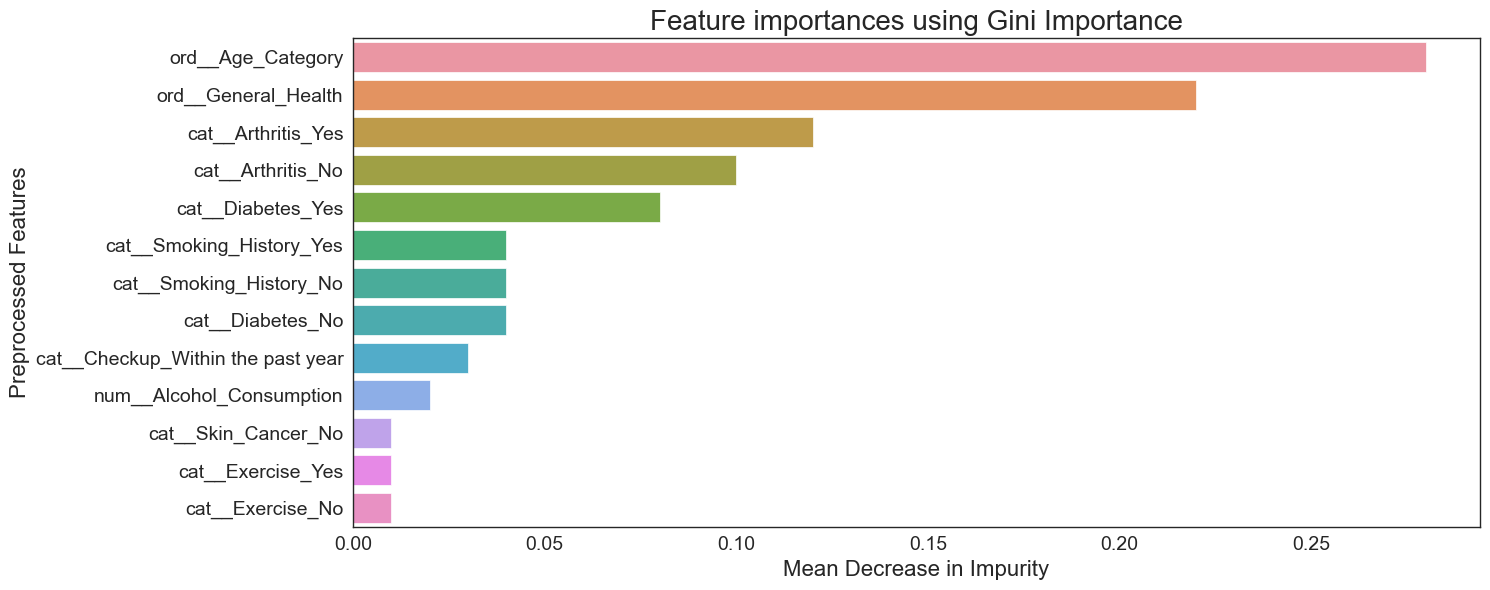

In [47]:
gini_importances = model[1].feature_importances_
std = np.std([tree.feature_importances_ for tree in model[1].estimators_], axis=0)

sorted_indcs = np.argsort(gini_importances)
sorted_indcs = sorted_indcs[::-1][:13]

importance_df = pd.DataFrame({
    'Feature': feature_names[sorted_indcs], 
    'Importance': gini_importances[sorted_indcs], 
    'Std': std[sorted_indcs]})

plt.figure(figsize=(15, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature importances using Gini Importance", fontsize = 20)
plt.xlabel("Mean Decrease in Impurity", fontsize = 16)
plt.ylabel("Preprocessed Features", fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14) 
plt.tight_layout()
plt.savefig('../figures/Gini_importance_mean.png',dpi=300,bbox_inches="tight")

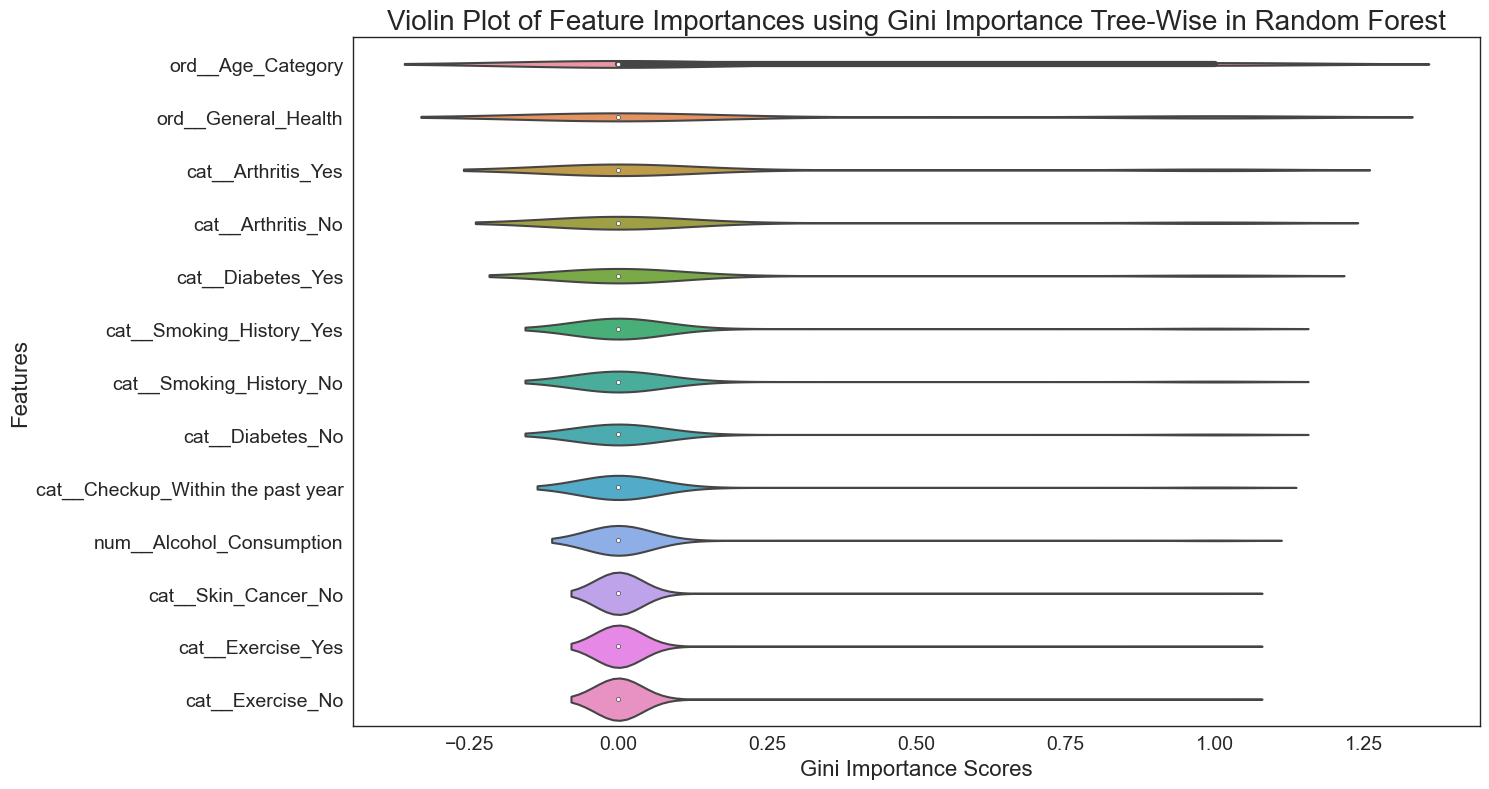

In [48]:
random_forest_model = model[1]
trees_feature_importances = np.array([tree.feature_importances_ for tree in random_forest_model.estimators_])
avg_feature_importances = np.mean(trees_feature_importances, axis=0)

sorted_indcs = np.argsort(avg_feature_importances)[::-1][:13]

indiv_trees_importances_df = pd.DataFrame(trees_feature_importances[:, sorted_indcs], columns=np.array(feature_names)[sorted_indcs])

plt.figure(figsize=(15, 8))
sns.violinplot(data=indiv_trees_importances_df, orient = 'h')
plt.title('Violin Plot of Feature Importances using Gini Importance Tree-Wise in Random Forest', fontsize = 20)
plt.xlabel('Gini Importance Scores',fontsize = 16)
plt.ylabel('Features',fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14) 
plt.tight_layout()
plt.savefig('../figures/Gini_importance_distribution.png',dpi=300,bbox_inches="tight")

#### Global Feature importance -- Permutation Importance

In [49]:
pipe = model[0]
rf_estimator = model[1]
df_test = pipe.transform(X_test)

In [50]:
weights = np.where(y_test == 1, 15, 1)
from sklearn.inspection import permutation_importance
result_detailed = permutation_importance(rf_estimator, df_test, y_test, n_repeats=10, random_state=42, 
                                scoring='recall', 
                                sample_weight=weights,
                                n_jobs=-1
                                )

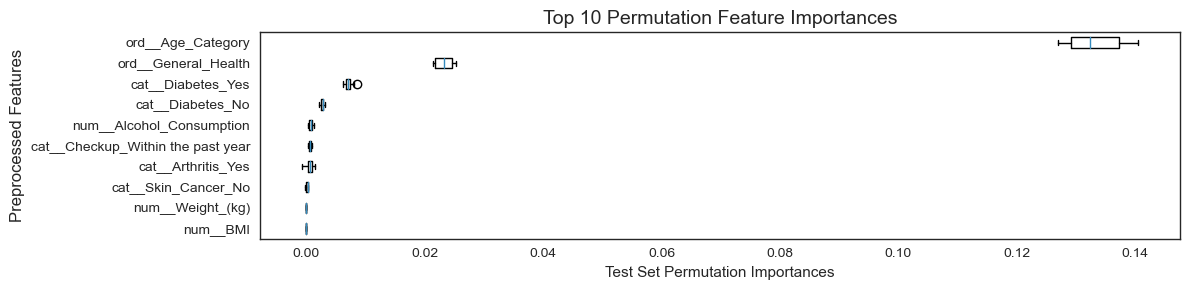

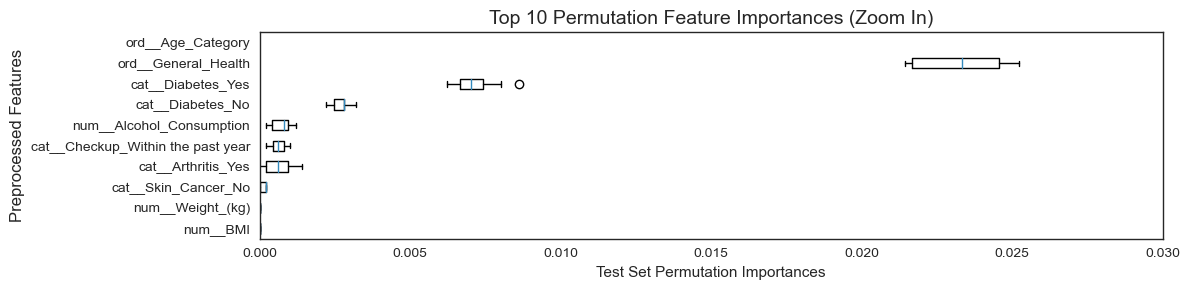

In [51]:
df_test = pd.DataFrame(df_test, columns=pipe.get_feature_names_out())

imp_mean = result_detailed.importances_mean
imp_std = result_detailed.importances_std
ftr_names = df_test.columns

sorted_indcs = np.argsort(imp_mean)[::-1]
sorted_indcs = sorted_indcs[:10][::-1]

plt.figure(figsize=(12, 3))
plt.boxplot(result_detailed.importances[sorted_indcs].T, labels=ftr_names[sorted_indcs], vert=False)
plt.title("Top 10 Permutation Feature Importances", fontsize = 14)
plt.xlabel('Test Set Permutation Importances', fontsize = 11)
plt.ylabel('Preprocessed Features', fontsize =12)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10) 
plt.tight_layout()
plt.savefig('../figures/permutation_preprocessed_importance_full.png',dpi=300,bbox_inches="tight")

plt.figure(figsize=(12, 3))
plt.boxplot(result_detailed.importances[sorted_indcs].T, labels=ftr_names[sorted_indcs], vert=False)
plt.xlim(0,0.03)
plt.title("Top 10 Permutation Feature Importances (Zoom In)",fontsize = 14)
plt.xlabel('Test Set Permutation Importances', fontsize = 11)
plt.ylabel('Preprocessed Features', fontsize =12)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10) 
plt.tight_layout()
plt.savefig('../figures/permutation_preprocessed_importance_zoom.png',dpi=300,bbox_inches="tight")

#### SHAP Global

In [52]:
shap.initjs()

In [53]:
explainer = shap.TreeExplainer(rf_estimator)
shap_values = explainer.shap_values(df_test)
print(np.shape(shap_values))

(2, 61771, 32)


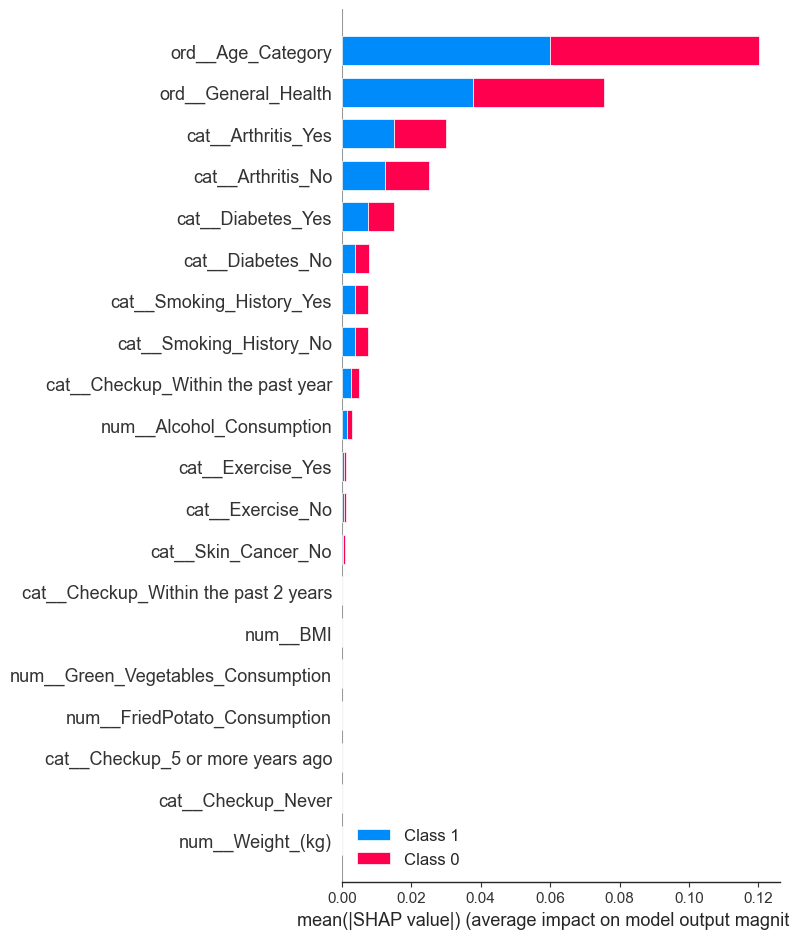

In [54]:
plt.figure(figsize=(15, 6))
shap.summary_plot(shap_values, df_test, feature_names=ftr_names)

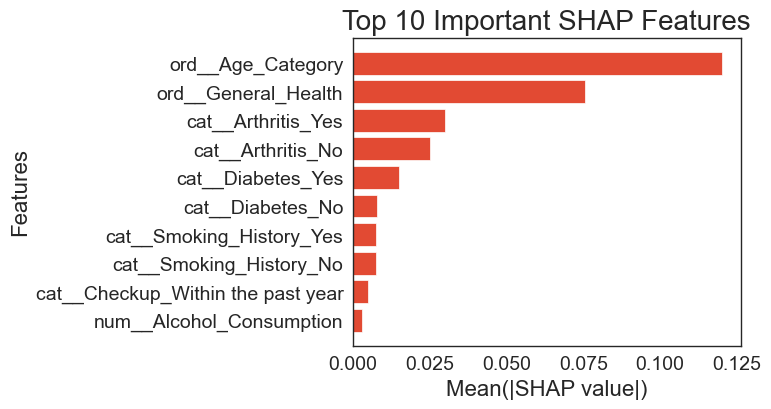

In [55]:
shap_summary = (np.sum(np.abs(shap_values[1]), axis=0) + np.sum(np.abs(shap_values[0]), axis=0)) / len(shap_values[0])

indcs = np.argsort(shap_summary)
shap_summary[indcs]

plt.figure(figsize=(5,4))
plt.barh(ftr_names[indcs[-10:]],shap_summary[indcs[-10:]])
plt.title("Top 10 Important SHAP Features", fontsize  = 20)
plt.xlabel('Mean(|SHAP value|)', fontsize = 16)
plt.ylabel('Features', fontsize = 16)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14) 
plt.savefig('../figures/SHAP_top10.png',dpi=300,bbox_inches="tight")

### Local

#### SHAP values for local feature importance

In [56]:
y_test_check = y_test.reset_index(drop=True)

In [57]:
index = 20000 # the index of the point to explain
print(explainer.expected_value[1]) # we explain class 1 predictions
print(y_test_check[index])
shap.force_plot(explainer.expected_value[1], shap_values[1][index,:], features = df_test.iloc[index,:],feature_names = ftr_names)

0.5688090731954405
0


In [58]:
index = 40000 # the index of the point to explain
print(explainer.expected_value[1]) # we explain class 1 predictions
print(y_test_check[index])
shap.force_plot(explainer.expected_value[1], shap_values[1][index,:], features = df_test.iloc[index,:],feature_names = ftr_names)

0.5688090731954405
1
